In [1]:
import sys
import itertools
import statistics
import shutil
import random
import math
from functools import reduce
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import seaborn as sns
import gc
import os
import psutil
import inspect
import re
import pickle
import torch
import datetime
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
import time
from IPython.core.interactiveshell import InteractiveShell  
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

In [2]:
import os
import tempfile
import warnings

import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
# import scrublet as scr
import scvi
import torch
import psutil

scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

sc.set_figure_params(figsize=(4, 4), frameon=False)
torch.set_float32_matmul_precision("high")
save_dir = './'
warnings.simplefilter(action="ignore", category=FutureWarning)

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

D:\aaa-new\setups\conda\conda-files\envs\scvi-tools\lib\site-packages\scvi\_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
D:\aaa-new\setups\conda\conda-files\envs\scvi-tools\lib\site-packages\scvi\_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
Global seed set to 0


Last run with scvi-tools version: 1.0.4


In [3]:
def same_seeds(seed=None):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def print_memory_used():
    process = psutil.Process()  
    memory_usage = process.memory_info().rss / 1024 / 1024 /1024 
    print(f"memory used: {memory_usage} GB")  

def print_anndata(input_adata=None):
    new_anndata = input_adata
    print(new_anndata)
    print(new_anndata.obs_names)
    print(new_anndata.var_names)
    print(new_anndata.X.max())
    print(new_anndata.obs)
    print(new_anndata.var)

def preprocessing(input_adata=None,if_filter_genes=True,if_norm=True,if_hvg=False,n_top_hvgs=None):
    new_anndata = input_adata
    if if_filter_genes==True:
        sc.pp.filter_genes(new_anndata, min_cells=1)
        print('Genes filtered.')
    if if_norm==True:
        if new_anndata.X.max() > 50:
            sc.pp.normalize_total(new_anndata, target_sum=1e4)
            sc.pp.log1p(new_anndata)
            print('Data normalized.')
    new_anndata.var_names_make_unique()
    new_anndata.obs_names_make_unique()
    print('Names are changed to be unique.')
    if if_hvg==True:
        if n_top_hvgs is not None:
            sc.pp.highly_variable_genes(new_anndata,n_top_genes=2048)
        else:
            sc.pp.highly_variable_genes(new_anndata)
        sc.pl.highly_variable_genes(new_anndata)
        new_anndata = new_anndata[:, new_anndata.var.highly_variable]
        print('Hvgs selected.')
    return new_anndata

def split_anndata_by_celltype_to_train_valid_test(new_anndata=None, celltype_label='celltype', split_ratio=[0.8,0.1,0.1], random_seed=42):  
    # split adata to three part by given ratio
    np.random.seed(random_seed)
    train_anndata = None
    valid_anndata = None
    test_anndata = None
    
    for celltype in new_anndata.obs[celltype_label].unique(): 
        celltype_indices = new_anndata.obs[celltype_label] == celltype  
        celltype_data = new_anndata[celltype_indices]  
        
        total_cells = len(celltype_data)  
        x, y, z = split_ratio  
        x_count = int(total_cells * x / (x + y + z))  
        y_count = int(total_cells * y / (x + y + z))  
        z_count = total_cells - x_count - y_count  
        
        indices = np.random.permutation(total_cells)  
        train_indices = indices[:x_count]  
        valid_indices = indices[x_count:x_count + y_count]  
        test_indices = indices[x_count + y_count:]  
        
        train_data = celltype_data[train_indices]  
        valid_data = celltype_data[valid_indices]  
        test_data = celltype_data[test_indices]  
        
        if train_anndata is None:
            train_anndata = train_data
        else:
            train_anndata = train_anndata.concatenate(train_data, index_unique=None)  
        if valid_anndata is None:
            valid_anndata = valid_data
        else:
            valid_anndata = valid_anndata.concatenate(valid_data, index_unique=None)   
        if test_anndata is None:
            test_anndata = test_data
        else:
            test_anndata = test_anndata.concatenate(test_data, index_unique=None)   
        
    return train_anndata, valid_anndata, test_anndata

def generate_datas_and_labels(input_adatas=None, the_length=None, if_balance_train_data=None, random_sample_num=None):
    new_anndata_train = input_adatas[0]
    new_anndata_valid = input_adatas[1]
    new_anndata_test = input_adatas[2]
    pcma = PCmaster_anno_0()
    train_data,mapping_1,mapping_2 = pcma.auto_annotation_with_deep_learning_transfer_adata_to_df_for_all_0(
        adata_input = new_anndata_train, the_length=the_length)
    valid_data,_,_ = pcma.auto_annotation_with_deep_learning_transfer_adata_to_df_for_all_0(
        adata_input = new_anndata_valid, the_length=the_length)
    test_data,_,_ = pcma.auto_annotation_with_deep_learning_transfer_adata_to_df_for_all_0(
        adata_input = new_anndata_test, the_length=the_length)
    
    # displays the number of categories and the number of each category.
    category_counts = train_data['celltype'].value_counts()
    print("the number of categories: ", len(category_counts))
    print("the number of each category: ")
    print(category_counts)
    print(mapping_1)
    print(mapping_2)
    
    if if_balance_train_data is True:
        train_data_balanced = pd.DataFrame()
        for category in category_counts.index:
            category_data = train_data[train_data['celltype'] == category]
            print(category)
            print(category_data.shape[0])
            # print(type(category_data.shape[0]))
            category_data = category_data.sample(n=random_sample_num, random_state=1, replace=True)
            train_data_balanced = pd.concat([train_data_balanced, category_data])
        train_data = train_data_balanced
    
    print_memory_used() 
    
    train_label = train_data.iloc[:, -1:]
    train_data = train_data.iloc[:, :-2]
    valid_label = valid_data.iloc[:, -1:]
    valid_data = valid_data.iloc[:, :-2]
    test_label = test_data.iloc[:, -1:]
    test_data = test_data.iloc[:, :-2]
    
    return train_data,train_label,valid_data,valid_label,test_data,test_label,mapping_1,mapping_2,category_counts

# GPU
def evaluate_accuracy_gpu(net, data_iter, device=None): 
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# GPU
def train_with_GPU(net=None, train_iter=None, valid_iter=None, num_epochs=None, lr=None, device=None, optimizer='Adam', momentum=None):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    if optimizer == 'SGD':
        if momentum is not None:
            optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)
        else:
            optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    if optimizer == 'Adam':
        optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150, eta_min=0.00001)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],ylim=[0,1],
                            legend=['train loss', 'train acc', 'valid acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    best_model_weights = None
    best_valid_acc = 0.0
    best_epoch = 0
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            scheduler.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        valid_acc = evaluate_accuracy_gpu(net, valid_iter)
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            best_epoch = epoch
            best_model_weights = net.state_dict()
        animator.add(epoch + 1, (None, None, valid_acc))
    net.load_state_dict(best_model_weights)
    print(f'At the epoch {best_epoch}, the model got the best valid accuracy {best_valid_acc}.')
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'valid acc {valid_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

def get_accuracy_precision_recall_f1_score(test_label=None,predicted=None):
    accuracy = accuracy_score(test_label, predicted)  
    # macro precision 
    macro_precision = precision_score(test_label, predicted, average='macro', zero_division=1)  
    
    # macro recall  
    macro_recall = recall_score(test_label, predicted, average='macro', zero_division=1)  
    
    # macro F1 score
    macro_f1_score = f1_score(test_label, predicted, average='macro', zero_division=1)  
    
    print("Accuracy:", accuracy)  
    print("Macro Precision:", macro_precision)  
    print("Macro Recall:", macro_recall)  
    print("Macro F1 Score:", macro_f1_score)
    
    return accuracy, macro_precision, macro_recall, macro_f1_score

In [ ]:
# scvi-tools

renames = []
reorgans = []
renumofcells = []
renumofcelltypes = []
rerandomseeds = []
reaccuracys = []
remacrof1scores = []
root_dir = 'E:/scplantdb-max-1500-per-cell-type/'
files = os.listdir(root_dir)
filepath_list = None
random_seeds = range(40,56)
if_norm=True
if_hvg=True
n_top_hvgs=None
celltype_label = 'Celltype'
organ_label = 'Organ'
split_ratio=[0.8,0.1,0.1]
if_df = False
if_feature_len = True
if_balance_train_data = True
random_sample_num = 1500
the_batch_size=256
lr=0.0004
dropout_ratio1=0.2
dropout_ratio2=0.1 # not use
dropout_ratio3=0.1 # not use
epochs=60
gpu_code=3
the_num_workers=0
the_num_heads=64 # for CIForm
the_optimizer='Adam'
the_momentum=None

for random_seed in random_seeds:
    print(f'random_seed = {random_seed}')
    same_seeds(seed = random_seed)
    for file in files:
        try:
            if not file.endswith('.h5ad'):
                continue
            file_path = root_dir+file
            if filepath_list is not None:
                if file_path not in filepath_list:
                    continue
            new_anndata = sc.read(file_path)
            organ = str(list(new_anndata.obs[organ_label])[0])
            numofcells = len(new_anndata.obs_names)
            new_anndata = preprocessing(input_adata=new_anndata,if_filter_genes=True,
                                if_norm=if_norm,if_hvg=if_hvg,n_top_hvgs=n_top_hvgs)
            print_anndata(input_adata=new_anndata)
            num_classes = len(new_anndata.obs[celltype_label].value_counts())
            numofcelltypes = num_classes
            
            feature_len = len(new_anndata.var_names)
            print(f'feature_len = {feature_len}')
            
            print_memory_used()
            
            new_anndata.obs['cellname'] = new_anndata.obs_names
            new_anndata.obs['celltype'] = new_anndata.obs[celltype_label]
            new_anndata_train, new_anndata_valid, new_anndata_test = split_anndata_by_celltype_to_train_valid_test(
                new_anndata=new_anndata, celltype_label=celltype_label, split_ratio=split_ratio, random_seed=random_seed,
            )
            del new_anndata
            gc.collect()
            if if_df is True:
                train_data,train_label,valid_data,valid_label,test_data,test_label,mapping_1,mapping_2,category_counts = generate_datas_and_labels(
                    input_adatas = [new_anndata_train, new_anndata_valid, new_anndata_test],
                    the_length = int(math.sqrt(feature_len) + 1),
                    if_balance_train_data = if_balance_train_data,
                    random_sample_num = random_sample_num,
                )
                del new_anndata_train, new_anndata_valid, new_anndata_test
                gc.collect()
            if if_feature_len is True and if_df is True:
                train_data = train_data.iloc[:,:feature_len]
                valid_data = valid_data.iloc[:,:feature_len]
                test_data = test_data.iloc[:,:feature_len]

            scvi.model.SCVI.setup_anndata(new_anndata_train, layer="counts")

            scvi_ref = scvi.model.SCVI(
                new_anndata_train,
                use_layer_norm="both",
                use_batch_norm="none",
                encode_covariates=True,
                dropout_rate=dropout_ratio1,
                n_layers=2,
            )
            scvi_ref.train()
            SCVI_LATENT_KEY = "X_scVI"
            new_anndata_train.obsm[SCVI_LATENT_KEY] = scvi_ref.get_latent_representation()
            sc.pp.neighbors(new_anndata_train, use_rep=SCVI_LATENT_KEY)
            sc.tl.leiden(new_anndata_train)
            sc.tl.umap(new_anndata_train)
            sc.pl.umap(
                new_anndata_train,
                color=[celltype_label],
                frameon=False,
                ncols=1,
            )
                
            # model, accuracy, macro_precision, macro_recall, macro_f1_score = train_CIForm(
            #     train_data=train_data,train_label=train_label,
            #     valid_data=valid_data,valid_label=valid_label,
            #     test_data=test_data,test_label=test_label,
            #     the_batch_size=the_batch_size,num_classes=num_classes,
            #     lr=lr,dropout_ratio1=dropout_ratio1,dropout_ratio2=dropout_ratio2,dropout_ratio3=dropout_ratio3,feature_len=feature_len,
            #     epochs=epochs,gpu_code=gpu_code,the_num_workers=the_num_workers,the_num_heads=the_num_heads,
            #     optimizer=the_optimizer,momentum=the_momentum,
            # )
            # 
            # renames.append(file.replace('.h5ad',''))
            # reorgans.append(organ)
            # renumofcells.append(numofcells)
            # renumofcelltypes.append(numofcelltypes)
            # rerandomseeds.append(random_seed)
            # reaccuracys.append(accuracy)
            # remacrof1scores.append(macro_f1_score)
            break
        except Exception:
            renames.append(file.replace('.h5ad',''))
            reorgans.append('-1')
            renumofcells.append(-1)
            renumofcelltypes.append(-1)
            rerandomseeds.append(-1)
            reaccuracys.append(-1)
            remacrof1scores.append(-1)
            break
    break

random_seed = 40
Genes filtered.
Data normalized.
Names are changed to be unique.


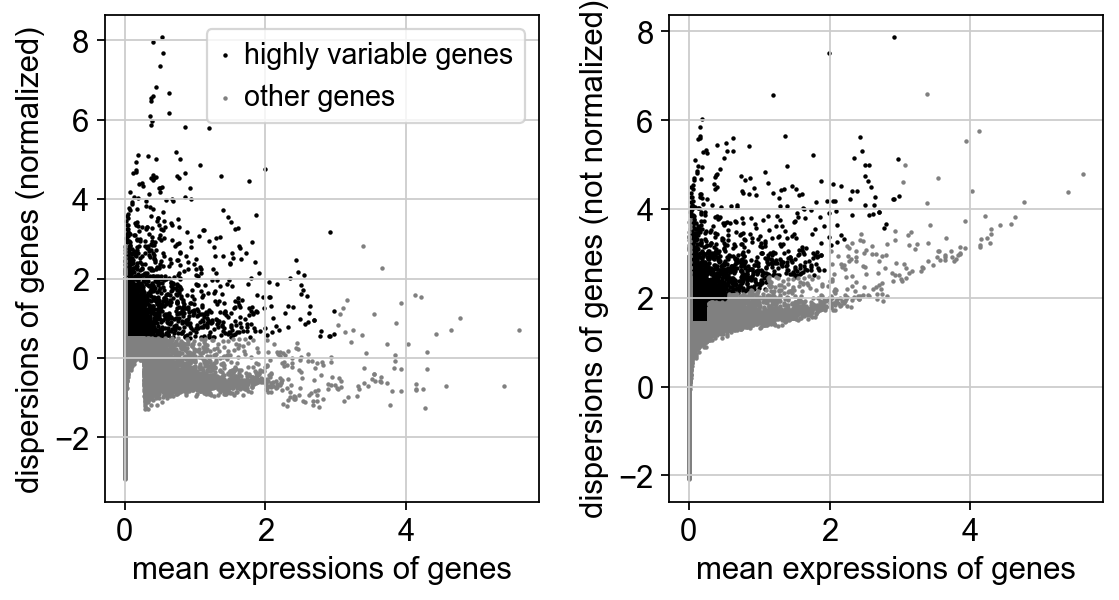

Hvgs selected.
View of AnnData object with n_obs × n_vars = 5153 × 7476
    obs: 'Orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent.mt', 'Seurat_clusters', 'Celltype', 'Dataset', 'Tissue', 'Organ', 'Condition', 'Genotype', 'Libraries', 'ACE', 'batch'
    var: 'features', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_tsne', 'X_umap'
Index(['CRX125602@@_AAACCTGGTTCGCGAC-1', 'CRX125602@@_AAAGATGAGCAATCTC-1',
       'CRX125602@@_AAAGATGAGCTCTCGG-1', 'CRX125602@@_AAAGATGTCATCATTC-1',
       'CRX125602@@_AAAGATGTCTGCCCTA-1', 'CRX125602@@_AAAGCAACAATGGATA-1',
       'CRX125602@@_AAAGCAATCAGCTTAG-1', 'CRX125602@@_AAAGTAGAGCGAAGGG-1',
       'CRX125602@@_AAAGTAGCAATGGTCT-1', 'CRX125602@@_AAAGTAGCATGGATGG-1',
       ...
       'CRX125602@@_TTGCCGTTCCACGACG-1', 'CRX125602@@_TTGGAACCAGTTCCCT-1',
       'CRX125602@@_TTTATGCAGCTTATCG-1', 'CRX125602@@_TTTATGCTCCAGAGGA-1',
       'CRX125602@@_TTTATGCTCTCGGACG-1', 'CRX125602@@_TTTATGCTCT

C:\Users\86135\AppData\Local\Temp\ipykernel_19232\1712628686.py:61: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  new_anndata.obs['cellname'] = new_anndata.obs_names
D:\aaa-new\setups\conda\conda-files\envs\scvi-tools\lib\site-packages\scvi\data\fields\_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/10:   0%|                                                                               | 0/10 [00:00<?, ?it/s]

D:\aaa-new\setups\conda\conda-files\envs\scvi-tools\lib\site-packages\scvi\module\_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)
D:\aaa-new\setups\conda\conda-files\envs\scvi-tools\lib\site-packages\scvi\module\_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 2/10:  10%|█          | 1/10 [00:02<00:26,  2.97s/it, v_num=1, train_loss_step=1.76e+3, train_loss_epoch=2.02e+3]

D:\aaa-new\setups\conda\conda-files\envs\scvi-tools\lib\site-packages\scvi\module\_vae.py:477: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs["px"].log_prob(x).sum(-1)


Epoch 10/10: 100%|█████████| 10/10 [00:29<00:00,  2.91s/it, v_num=1, train_loss_step=1.59e+3, train_loss_epoch=1.58e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|█████████| 10/10 [00:29<00:00,  3.00s/it, v_num=1, train_loss_step=1.59e+3, train_loss_epoch=1.58e+3]
INFO     Training for 20 epochs.                                                                                   


D:\aaa-new\setups\conda\conda-files\envs\scvi-tools\lib\site-packages\scvi\data\fields\_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/20:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

D:\aaa-new\setups\conda\conda-files\envs\scvi-tools\lib\site-packages\scvi\module\_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)
D:\aaa-new\setups\conda\conda-files\envs\scvi-tools\lib\site-packages\scvi\module\_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 2/20:   5%|▌          | 1/20 [00:03<01:06,  3.51s/it, v_num=1, train_loss_step=1.67e+3, train_loss_epoch=1.67e+3]

D:\aaa-new\setups\conda\conda-files\envs\scvi-tools\lib\site-packages\scvi\module\_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 20/20: 100%|█████████| 20/20 [01:11<00:00,  3.50s/it, v_num=1, train_loss_step=1.59e+3, train_loss_epoch=1.57e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|█████████| 20/20 [01:11<00:00,  3.59s/it, v_num=1, train_loss_step=1.59e+3, train_loss_epoch=1.57e+3]


In [4]:
# scvi-tools try

renames = []
reorgans = []
renumofcells = []
renumofcelltypes = []
rerandomseeds = []
reaccuracys = []
remacrof1scores = []
root_dir = 'E:/scplantdb-max-1500-per-cell-type/'
files = os.listdir(root_dir)
filepath_list = None
random_seeds = range(40,56)
if_norm=True
if_hvg=True
n_top_hvgs=None
celltype_label = 'Celltype'
organ_label = 'Organ'
split_ratio=[0.8,0.1,0.1]
if_df = False
if_feature_len = True
if_balance_train_data = True
random_sample_num = 1500
the_batch_size=256
lr=0.0004
dropout_ratio1=0.2
dropout_ratio2=0.1 # not use
dropout_ratio3=0.1 # not use
epochs=10
gpu_code=3
the_num_workers=0
the_num_heads=64 # for CIForm
the_optimizer='Adam'
the_momentum=None

for random_seed in random_seeds:
    print(f'random_seed = {random_seed}')
    same_seeds(seed = random_seed)
    for file in files:
        # try:
        if not file.endswith('.h5ad'):
            continue
        file_path = root_dir+file
        if filepath_list is not None:
            if file_path not in filepath_list:
                continue
        new_anndata = sc.read(file_path)
        organ = str(list(new_anndata.obs[organ_label])[0])
        numofcells = len(new_anndata.obs_names)
        new_anndata = preprocessing(input_adata=new_anndata,if_filter_genes=True,
                            if_norm=if_norm,if_hvg=if_hvg,n_top_hvgs=n_top_hvgs)
        print_anndata(input_adata=new_anndata)
        num_classes = len(new_anndata.obs[celltype_label].value_counts())
        numofcelltypes = num_classes
        
        feature_len = len(new_anndata.var_names)
        print(f'feature_len = {feature_len}')
        
        print_memory_used()
        
        new_anndata.obs['cellname'] = new_anndata.obs_names
        new_anndata.obs['celltype'] = new_anndata.obs[celltype_label]
        new_anndata_train, new_anndata_valid, new_anndata_test = split_anndata_by_celltype_to_train_valid_test(
            new_anndata=new_anndata, celltype_label=celltype_label, split_ratio=split_ratio, random_seed=random_seed,
        )
        del new_anndata
        gc.collect()
        if if_df is True:
            train_data,train_label,valid_data,valid_label,test_data,test_label,mapping_1,mapping_2,category_counts = generate_datas_and_labels(
                input_adatas = [new_anndata_train, new_anndata_valid, new_anndata_test],
                the_length = int(math.sqrt(feature_len) + 1),
                if_balance_train_data = if_balance_train_data,
                random_sample_num = random_sample_num,
            )
            del new_anndata_train, new_anndata_valid, new_anndata_test
            gc.collect()
        if if_feature_len is True and if_df is True:
            train_data = train_data.iloc[:,:feature_len]
            valid_data = valid_data.iloc[:,:feature_len]
            test_data = test_data.iloc[:,:feature_len]
            
        scvi.model.SCVI.setup_anndata(new_anndata_train)
        
        scvi_ref = scvi.model.SCVI(
            new_anndata_train,
            use_layer_norm="both",
            use_batch_norm="none",
            encode_covariates=True,
            dropout_rate=dropout_ratio1,
            n_layers=2,
        )
        scvi_ref.train(max_epochs=epochs)
        SCVI_LATENT_KEY = "X_scVI"
        new_anndata_train.obsm[SCVI_LATENT_KEY] = scvi_ref.get_latent_representation()
        # sc.pp.neighbors(new_anndata_train, use_rep=SCVI_LATENT_KEY)
        # sc.tl.leiden(new_anndata_train)
        # sc.tl.umap(new_anndata_train)
        # sc.pl.umap(
        #     new_anndata_train,
        #     color=[celltype_label],
        #     frameon=False,
        #     ncols=1,
        # )
        # 
        # scvi.model.SCVI.prepare_query_anndata(new_anndata_test, scvi_ref)
        # scvi_query = scvi.model.SCVI.load_query_data(
        #     new_anndata_test,
        #     scvi_ref,
        # )
        SCANVI_LABELS_KEY = "labels_scanvi"
        new_anndata_train.obs[SCANVI_LABELS_KEY] = new_anndata_train.obs[celltype_label].values
        scanvi_ref = scvi.model.SCANVI.from_scvi_model(
            scvi_ref,
            unlabeled_category="Unknown",
            labels_key=SCANVI_LABELS_KEY,
        )
        scanvi_ref.train(max_epochs=epochs, n_samples_per_label=100)
        SCANVI_LATENT_KEY = "X_scANVI"

        new_anndata_train.obsm[SCANVI_LATENT_KEY] = scanvi_ref.get_latent_representation()
        sc.pp.neighbors(new_anndata_train, use_rep=SCANVI_LATENT_KEY)
        sc.tl.leiden(new_anndata_train)
        sc.tl.umap(new_anndata_train)
        
            # model, accuracy, macro_precision, macro_recall, macro_f1_score = train_CIForm(
            #     train_data=train_data,train_label=train_label,
            #     valid_data=valid_data,valid_label=valid_label,
            #     test_data=test_data,test_label=test_label,
            #     the_batch_size=the_batch_size,num_classes=num_classes,
            #     lr=lr,dropout_ratio1=dropout_ratio1,dropout_ratio2=dropout_ratio2,dropout_ratio3=dropout_ratio3,feature_len=feature_len,
            #     epochs=epochs,gpu_code=gpu_code,the_num_workers=the_num_workers,the_num_heads=the_num_heads,
            #     optimizer=the_optimizer,momentum=the_momentum,
            # )
            # 
            # renames.append(file.replace('.h5ad',''))
            # reorgans.append(organ)
            # renumofcells.append(numofcells)
            # renumofcelltypes.append(numofcelltypes)
            # rerandomseeds.append(random_seed)
            # reaccuracys.append(accuracy)
            # remacrof1scores.append(macro_f1_score)
        break
    #     except Exception:
    #         renames.append(file.replace('.h5ad',''))
    #         reorgans.append('-1')
    #         renumofcells.append(-1)
    #         renumofcelltypes.append(-1)
    #         rerandomseeds.append(-1)
    #         reaccuracys.append(-1)
    #         remacrof1scores.append(-1)
    #         break
    break

INFO     Found 100.0% reference vars in query data.                                                                
INFO     Training for 10 epochs.                                                                                   


D:\aaa-new\setups\conda\conda-files\envs\scvi-tools\lib\site-packages\scvi\data\fields\_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
D:\aaa-new\setups\conda\conda-files\envs\scvi-tools\lib\site-packages\lightning\pytorch\loops\fit_loop.py:281: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/10:   0%|                                                                               | 0/10 [00:00<?, ?it/s]

D:\aaa-new\setups\conda\conda-files\envs\scvi-tools\lib\site-packages\scvi\module\_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 2/10:  10%|█          | 1/10 [00:00<00:03,  2.65it/s, v_num=1, train_loss_step=1.54e+3, train_loss_epoch=1.53e+3]

D:\aaa-new\setups\conda\conda-files\envs\scvi-tools\lib\site-packages\scvi\module\_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 4/10:  30%|███▎       | 3/10 [00:01<00:02,  2.74it/s, v_num=1, train_loss_step=1.58e+3, train_loss_epoch=1.53e+3]

D:\aaa-new\setups\conda\conda-files\envs\scvi-tools\lib\site-packages\scvi\module\_scanvae.py:286: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -px.log_prob(x).sum(-1)


Epoch 10/10: 100%|█████████| 10/10 [00:03<00:00,  2.65it/s, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.53e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|█████████| 10/10 [00:03<00:00,  2.70it/s, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.53e+3]


Text(0, 0.5, 'Observed')

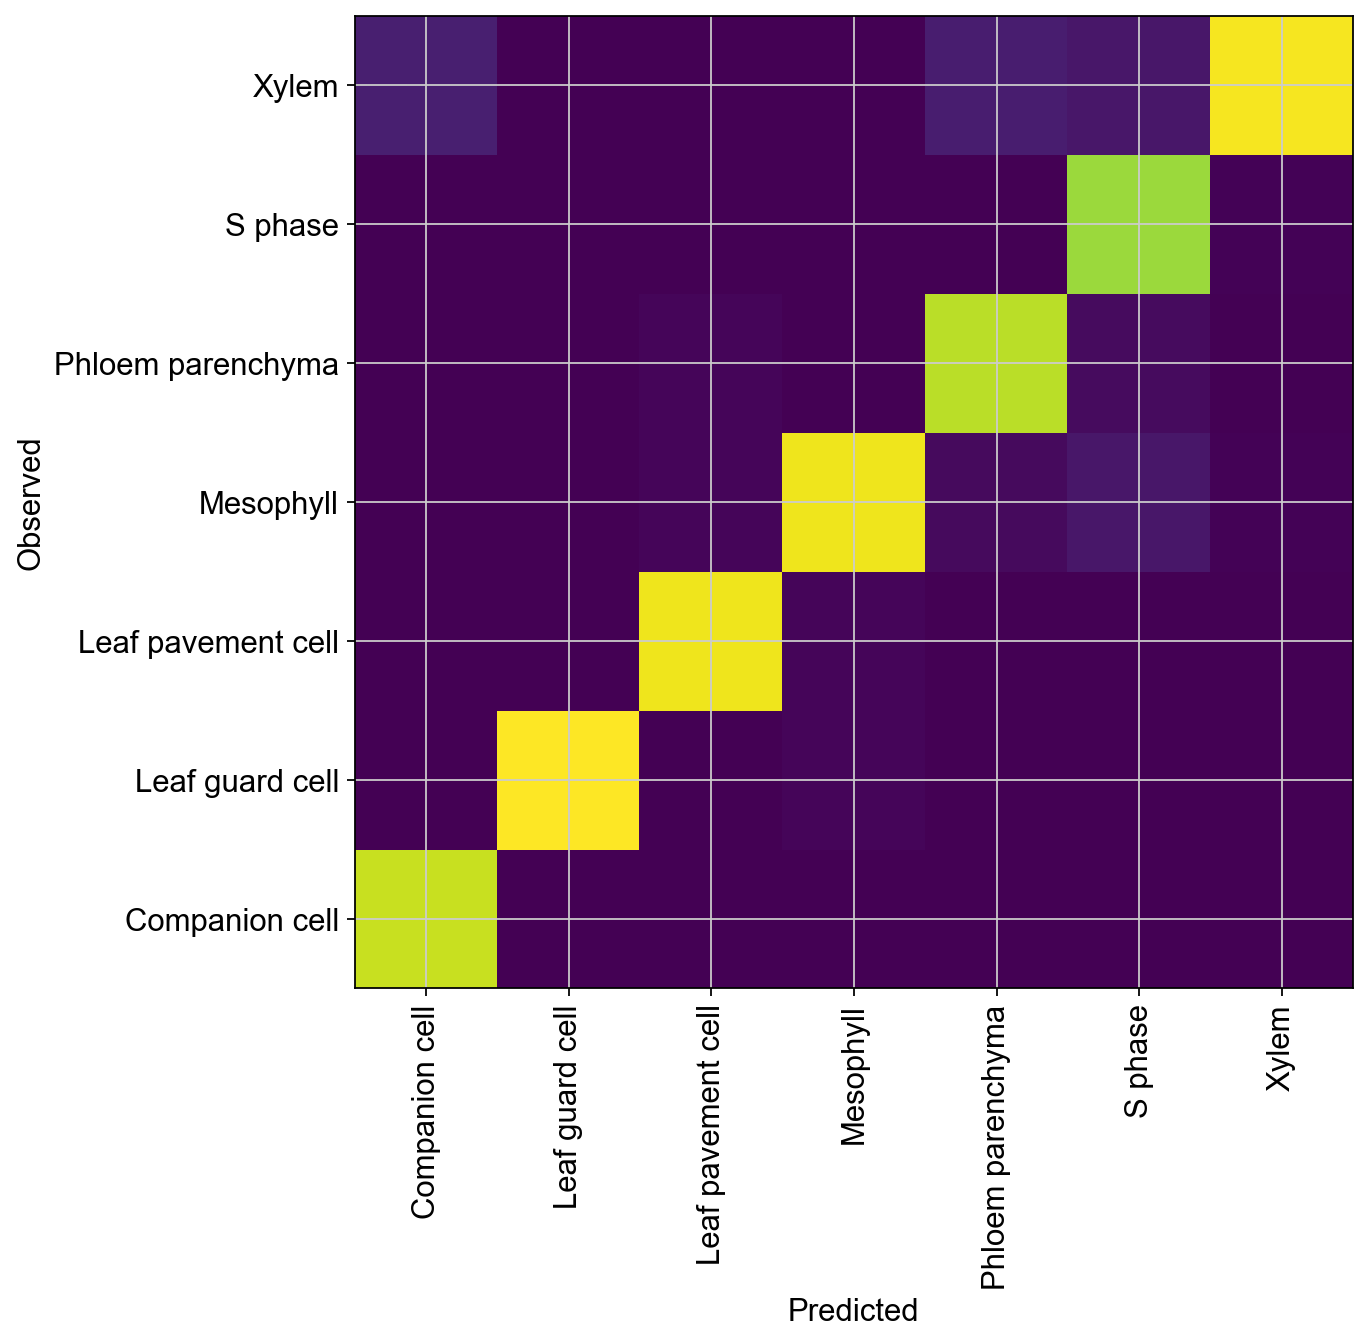

In [6]:
# again a no-op in this tutorial, but good practice to use
scvi.model.SCANVI.prepare_query_anndata(new_anndata_test, scanvi_ref)

scanvi_query = scvi.model.SCANVI.load_query_data(new_anndata_test, scanvi_ref)

scanvi_query.train(
    max_epochs=epochs,
    plan_kwargs={"weight_decay": 0.0},
    check_val_every_n_epoch=1,
)

SCANVI_PREDICTIONS_KEY = "predictions_scanvi"

new_anndata_test.obsm[SCANVI_LATENT_KEY] = scanvi_query.get_latent_representation()
new_anndata_test.obs[SCANVI_PREDICTIONS_KEY] = scanvi_query.predict()

df = (
    new_anndata_test.obs.groupby([celltype_label, SCANVI_PREDICTIONS_KEY])
    .size()
    .unstack(fill_value=0)
)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

CRX125602@@_TCTATTGGTCAAAGAT-1         Mesophyll
CRX125602@@_AGTAGTCAGTAGGTGC-1         Mesophyll
CRX125602@@_GACCAATTCATCGCTC-1         Mesophyll
CRX125602@@_TACTTACCATCAGTCA-1         Mesophyll
CRX125602@@_TTCCCAGCATGGTCAT-1         Mesophyll
                                       ...      
CRX125602@@_CATTATCCAAAGGTGC-1    Companion cell
CRX125602@@_TGTGGTAAGTAAGTAC-1    Companion cell
CRX125602@@_CTAGAGTCAGTCCTTC-1    Companion cell
CRX125602@@_GGCAATTCATTCGACA-1    Companion cell
CRX125602@@_GACGGCTTCCGCTGTT-1    Companion cell
Name: Celltype, Length: 519, dtype: category
Categories (7, object): ['Companion cell', 'Leaf guard cell', 'Leaf pavement cell', 'Mesophyll', 'Phloem parenchyma', 'S phase', 'Xylem']


D:\aaa-new\setups\conda\conda-files\envs\scvi-tools\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


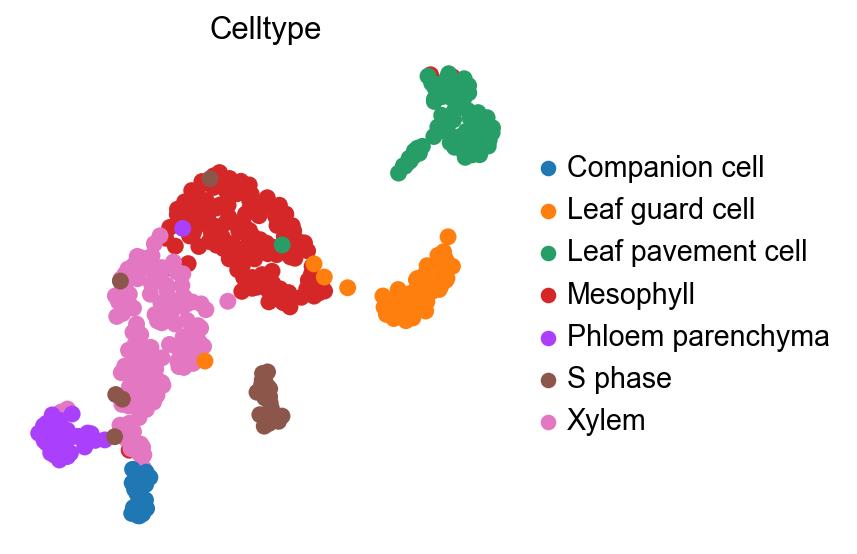

D:\aaa-new\setups\conda\conda-files\envs\scvi-tools\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


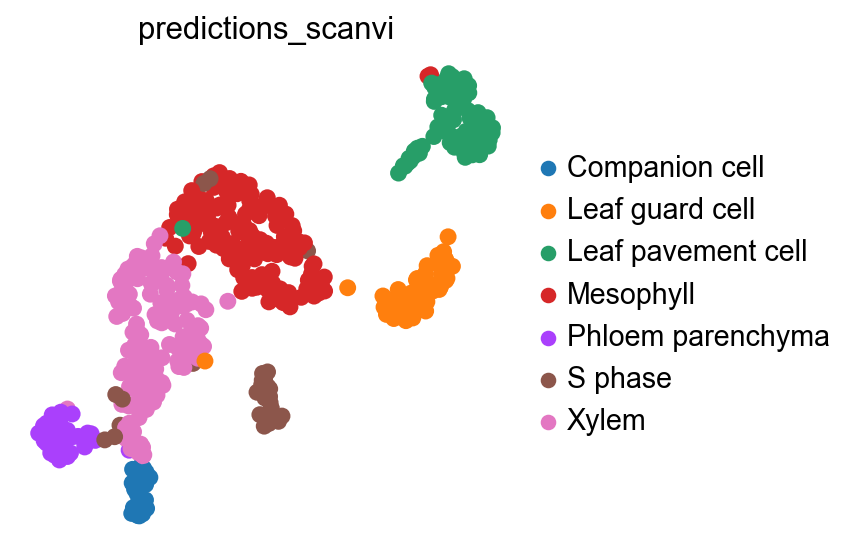

In [7]:
print(new_anndata_test.obs[celltype_label])

sc.pp.neighbors(new_anndata_test, use_rep=SCANVI_LATENT_KEY)
sc.tl.leiden(new_anndata_test)
sc.tl.umap(new_anndata_test)

sc.pl.umap(new_anndata_test,color=celltype_label)
sc.pl.umap(new_anndata_test,color=SCANVI_PREDICTIONS_KEY)
